In [1]:
#|default_exp 3c1_graph_construction_experiments
#|hide
## Standard libraries
import os
import math
import numpy as np
import time
# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm, trange

## project specifics
import diffusion_curvature
from diffusion_curvature.datasets import *
from diffusion_curvature.graphs import *
from diffusion_curvature.core import *
import jax
import jax.numpy as jnp
print(jax.devices())

%load_ext autoreload
%autoreload 2

[cuda(id=0)]


# 3d1 Effects of Graph Construction on Negative Curvature

In 3d, we noticed that the knn value has a suspiciously large effect on the signs of curvature measured. With $k=5$, DC has trouble picking up any negative curvature; with $k=15$, it struggles to identify anything as positive.

Here we'll test the method by probing its ability to separate saddles and spheres in various dimensions.

## Executive Summary:
1. Both the fixed and adaptive kernel significantly outperform Graphtools' graph construction on this toy data.
2. The median heuristic is not very good at choosing the right sigma.
3. The adaptive gaussian kernel with $k=10$ chooses the right sigma well, producing tightly clustered distinctions between the saddles and spheres.
4. Disabling the anisotropic density normalization *helps* performance in high dimensions, enabling the adaptive kernel + DC to detect negative curvature in higher-dimensional saddles.

# With Graphtools' Graphs

In [2]:
import graphtools
from diffusion_curvature.core import DiffusionCurvature
from diffusion_curvature.datasets import rejection_sample_from_saddle, sphere
from functools import partial

def graphtools_graph_from_data(X, knn = 15):
    return graphtools.Graph(X, anisotropy=1, knn=knn, decay=None).to_pygsp()
    
def get_dc_of_saddles_and_spheres(
    dim = 3,
    num_samplings = 100,
    graph_former = graphtools_graph_from_data,
    return_data = False,
):
    samplings = [2000]*num_samplings
    ks_dc_saddles = []
    ks_dc_spheres = []
    X_saddles_sampled = []
    X_spheres_sampled = []
    
    for n_points in tqdm(samplings):
        X_saddle, k_saddle = rejection_sample_from_saddle(n_points, dim)
        X_saddles_sampled.append(X_saddle)
        X_sphere, k_sphere = sphere(n_points, d=dim)
        X_spheres_sampled.append(X_sphere)
        # Compute Diffusion Curvature on Sphere
        G = graph_former(X_sphere)
        DC = DiffusionCurvature(
            laziness_method="Entropic",
            flattening_method="Fixed",
            comparison_method="Subtraction",
            graph_former = graph_former,
            points_per_cluster=None, # construct separate comparison spaces around each point
            comparison_space_size_factor=1
        )
        ks = DC.curvature(G, t=25, dim=dim, idx=0)
        ks_dc_spheres.append(ks)
        # Compute Diffusion Curvature on Saddle
        G = graph_former(X_saddle)
        DC = DiffusionCurvature(
            laziness_method="Entropic",
            flattening_method="Fixed",
            comparison_method="Subtraction",
            graph_former = graph_former,
            points_per_cluster=None, # construct separate comparison spaces around each point
            comparison_space_size_factor=1
        )
        ks = DC.curvature(G, t=25, dim=dim, idx=0)
        ks_dc_saddles.append(ks)
    
    # plot a histogram of the diffusion curvatures
    plt.hist(ks_dc_saddles, bins=50, color='orange', label = 'Saddles')
    plt.hist(ks_dc_spheres, bins=50, color='green', label = 'Spheres')
    plt.legend()
    plt.xlabel("Diffusion Curvature")
    plt.title(f"In dimension {dim}")
    # plt.xlabel('')
    # plt.ylabel('Frequency')
    if return_data: return ks_dc_saddles, ks_dc_spheres

In [3]:
get_dc_of_saddles_and_spheres(
    graph_former = partial(graphtools_graph_from_data, knn=15)
)

  0%|          | 0/100 [00:00<?, ?it/s]

TypeError: sparse array length is ambiguous; use getnnz() or shape[0]

In [ ]:
get_dc_of_saddles_and_spheres(
    graph_former = partial(graphtools_graph_from_data, knn=10)
)

In [ ]:
get_dc_of_saddles_and_spheres(
    graph_former = partial(graphtools_graph_from_data, knn=5)
)

In [ ]:
get_dc_of_saddles_and_spheres(
    graph_former = partial(graphtools_graph_from_data, knn=15),
    dim = 2
)

In [ ]:
get_dc_of_saddles_and_spheres(
    graph_former = partial(graphtools_graph_from_data, knn=10),
    dim = 2
)

In [ ]:
get_dc_of_saddles_and_spheres(
    graph_former = partial(graphtools_graph_from_data, knn=5),
    dim = 2
)

# With a Plain Gaussian Kernel

We observe that the variance between samplings is drastically reduced when using a plain gaussian kernel.

In [4]:
from diffusion_curvature.kernels import gaussian_kernel
from dataclasses import dataclass

@dataclass
class SimpleGraph:
    W: np.ndarray
    
def graph_from_gaussian_kernel(X, sigma = 0, alpha = 0):
    W = gaussian_kernel(
        X,
        kernel_type='fixed',
        sigma = sigma, # use median heuristic
        anisotropic_density_normalization = alpha,
    )
    G = SimpleGraph(W = W)
    return G

In [5]:
X, ks = sphere(1000)
G = graph_from_gaussian_kernel(X,sigma=0.7)
# assert np.allclose(G.W,gaussian_kernel(X, kernel_type='fixed',sigma=0, anisotropic_density_normalization=1), atol = 1e-9)

In [6]:
G.W

array([[0.56991754, 0.29680986, 0.04288912, ..., 0.2351118 , 0.11747229,
        0.02305512],
       [0.29680986, 0.56991754, 0.04735469, ..., 0.07031777, 0.41685696,
        0.07559061],
       [0.04288912, 0.04735469, 0.56991754, ..., 0.01755797, 0.09412042,
        0.02866372],
       ...,
       [0.2351118 , 0.07031777, 0.01755797, ..., 0.56991754, 0.02442851,
        0.04378498],
       [0.11747229, 0.41685696, 0.09412042, ..., 0.02442851, 0.56991754,
        0.12120653],
       [0.02305512, 0.07559061, 0.02866372, ..., 0.04378498, 0.12120653,
        0.56991754]])

In [7]:
D = np.diag(1/np.sum(G.W, axis=1))

In [9]:
np.max(G.W)

0.5699175434306182

In [10]:
from sklearn.metrics import pairwise_distances
from diffusion_curvature.kernels import median_heuristic
D = pairwise_distances(X)
median_heuristic(D)

0.9991981282990747

  0%|          | 0/100 [00:00<?, ?it/s]

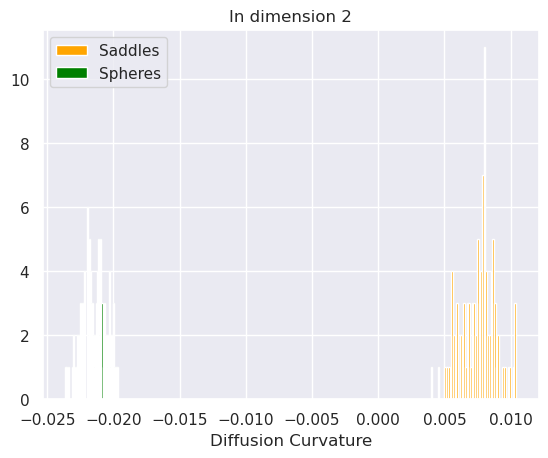

In [11]:
ksaddles, kspheres = get_dc_of_saddles_and_spheres(
    graph_former = graph_from_gaussian_kernel,
    dim = 2,
    return_data = True
)

(array([ 3.,  4.,  8., 10., 20., 11., 19.,  9.,  9.,  7.]),
 array([-0.02364445, -0.02324238, -0.02284031, -0.02243824, -0.02203617,
        -0.0216341 , -0.02123203, -0.02082996, -0.02042789, -0.02002583,
        -0.01962376]),
 <BarContainer object of 10 artists>)

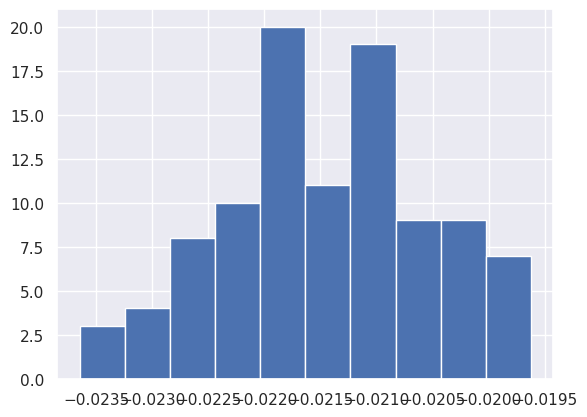

In [12]:
plt.hist(kspheres)

(array([ 2.,  2.,  9., 10., 11., 17., 26., 15.,  2.,  6.]),
 array([0.00396395, 0.00460873, 0.00525351, 0.00589828, 0.00654306,
        0.00718784, 0.00783262, 0.0084774 , 0.00912218, 0.00976696,
        0.01041174]),
 <BarContainer object of 10 artists>)

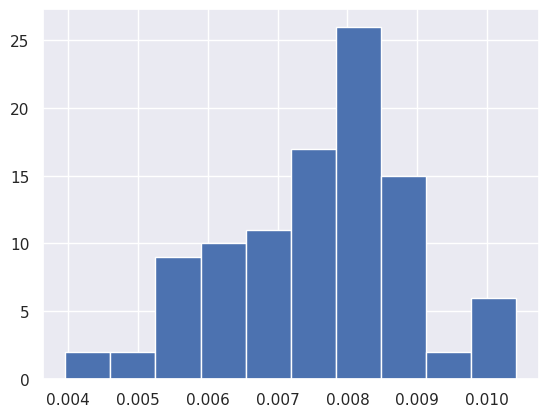

In [13]:
plt.hist(ksaddles)

Aha! Turns out 0.1 is the correct sigma value for this problem. 
Evidently the median heuristic is terrible for this use case.

Interestingly, with the right sigma parameter, the plain gaussian kernel separates spheres and saddles far more effectively than graphtools.

  0%|          | 0/100 [00:00<?, ?it/s]

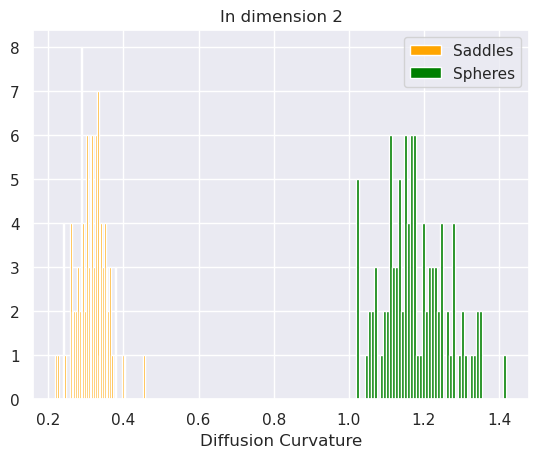

In [14]:
ksaddles, kspheres = get_dc_of_saddles_and_spheres(
    graph_former = partial(
        graph_from_gaussian_kernel, sigma=0.1, alpha=0),
    dim = 2, 
    return_data = True
)

(array([ 8.,  8., 19., 24., 11., 12.,  8.,  5.,  4.,  1.]),
 array([1.01980639, 1.05976343, 1.09972048, 1.13967752, 1.17963457,
        1.21959162, 1.25954866, 1.29950571, 1.33946276, 1.3794198 ,
        1.41937685]),
 <BarContainer object of 10 artists>)

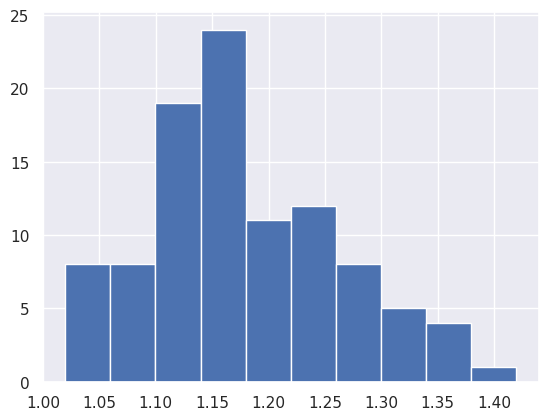

In [15]:
plt.hist(kspheres)

What happens with anisotropy now that we have the right sigma? I expect it to decrease the variance. It does, somewhat - but it also distorts the numbers. It would seem that negative curvature is somehow adversely affected by complete anisotropic normalization.

(array([ 6.,  7., 17., 21., 23., 16.,  7.,  2.,  0.,  1.]),
 array([0.21909618, 0.24295282, 0.26680946, 0.2906661 , 0.31452274,
        0.33837938, 0.36223602, 0.38609266, 0.4099493 , 0.43380594,
        0.45766258]),
 <BarContainer object of 10 artists>)

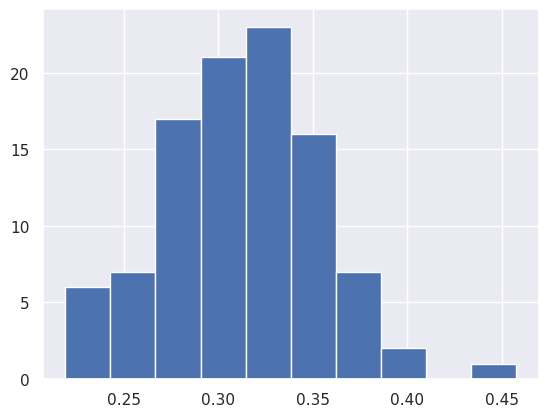

In [16]:
plt.hist(ksaddles)

  0%|          | 0/100 [00:00<?, ?it/s]

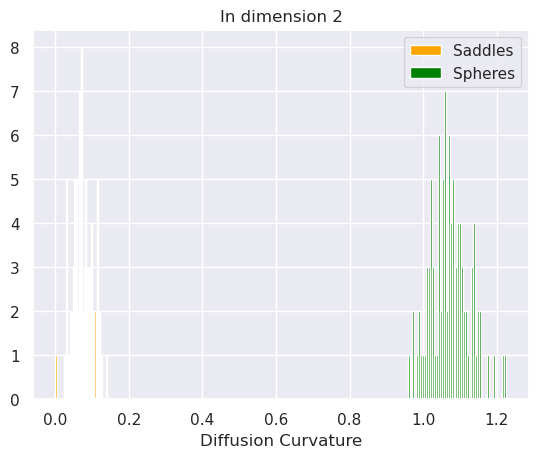

In [17]:
ksaddles, kspheres = get_dc_of_saddles_and_spheres(
    graph_former = partial(
        graph_from_gaussian_kernel, sigma=0.1, alpha=1),
    dim = 2, 
    return_data = True
)

(array([ 4.,  8., 13., 22., 21., 15.,  9.,  4.,  2.,  2.]),
 array([0.95982742, 0.9864279 , 1.01302838, 1.03962874, 1.06622922,
        1.0928297 , 1.11943018, 1.14603066, 1.17263103, 1.19923151,
        1.22583199]),
 <BarContainer object of 10 artists>)

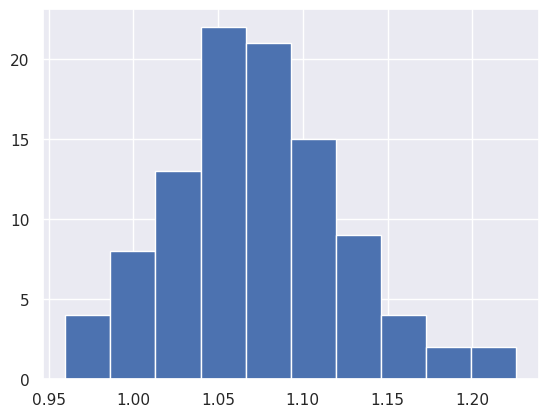

In [18]:
plt.hist(kspheres)

(array([ 1.,  1.,  9., 16., 19., 20., 11., 11., 11.,  1.]),
 array([0.00093365, 0.01487017, 0.02880669, 0.04274321, 0.05667973,
        0.07061625, 0.08455276, 0.09848928, 0.1124258 , 0.12636232,
        0.14029884]),
 <BarContainer object of 10 artists>)

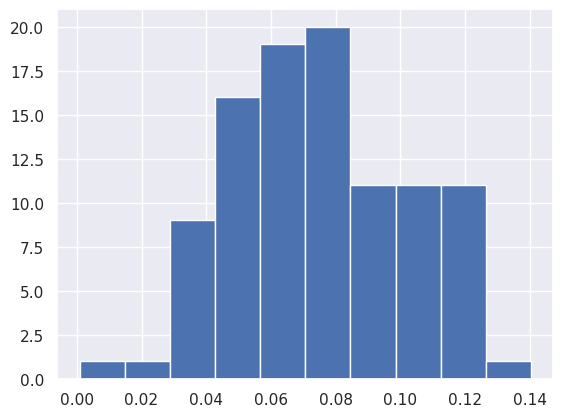

In [19]:
plt.hist(ksaddles)

# The Adaptive Kernel

I thought this was what graphtools was doing; evidently, I was woefully wrong. There's far less variance, and far more accurate readings here than with graphtools.

In [20]:
from diffusion_curvature.kernels import gaussian_kernel
from dataclasses import dataclass

def graph_from_adaptive_gaussian_kernel(X, k=10, alpha = 1):
    W = gaussian_kernel(
        X,
        kernel_type='adaptive',
        k = k,
        anisotropic_density_normalization = alpha,
    )
    G = SimpleGraph(W = W)
    return G

  0%|          | 0/100 [00:00<?, ?it/s]

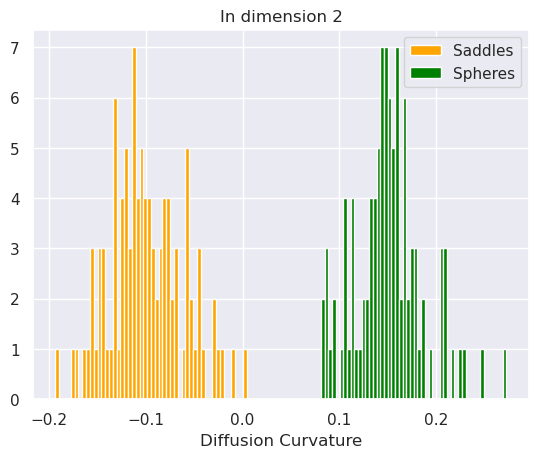

In [21]:
ksaddles, kspheres = get_dc_of_saddles_and_spheres(
    graph_former = partial(
        graph_from_adaptive_gaussian_kernel, k=10, alpha=1),
    dim = 2, 
    return_data = True
)

  0%|          | 0/100 [00:00<?, ?it/s]

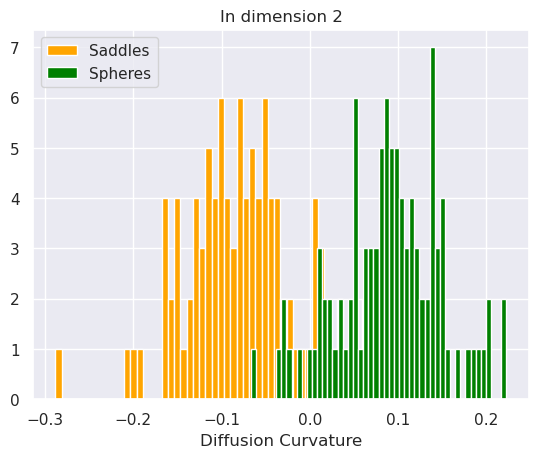

In [22]:
ksaddles, kspheres = get_dc_of_saddles_and_spheres(
    graph_former = partial(
        graph_from_adaptive_gaussian_kernel, k=5, alpha=1),
    dim = 2, 
    return_data = True
)

  0%|          | 0/100 [00:00<?, ?it/s]

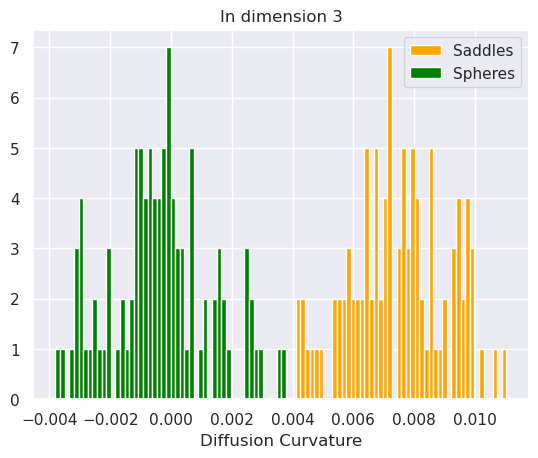

In [23]:
ksaddles, kspheres = get_dc_of_saddles_and_spheres(
    graph_former = partial(
        graph_from_adaptive_gaussian_kernel, k=10, alpha=1),
    dim = 3, 
    return_data = True
)

  0%|          | 0/100 [00:00<?, ?it/s]

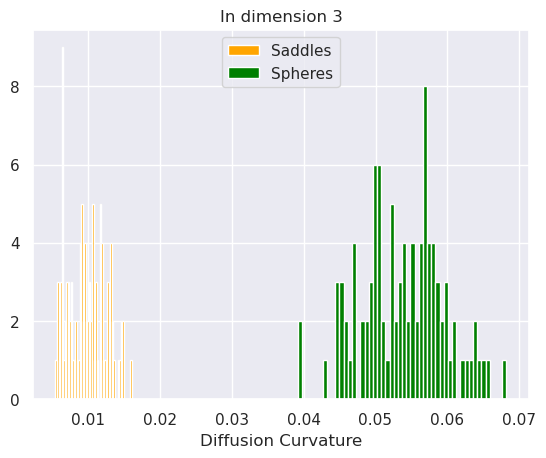

In [24]:
ksaddles, kspheres = get_dc_of_saddles_and_spheres(
    graph_former = partial(
        graph_from_adaptive_gaussian_kernel, k=5, alpha=1),
    dim = 3, 
    return_data = True
)

So it appears that my adaptive kernel function does a much better job of distinguishing between positive and negative. However, there is still some slippage in high dimensions. Where saddles are seen as positively curved. I suspect this relates to the problem of holes in the data.

  0%|          | 0/100 [00:00<?, ?it/s]

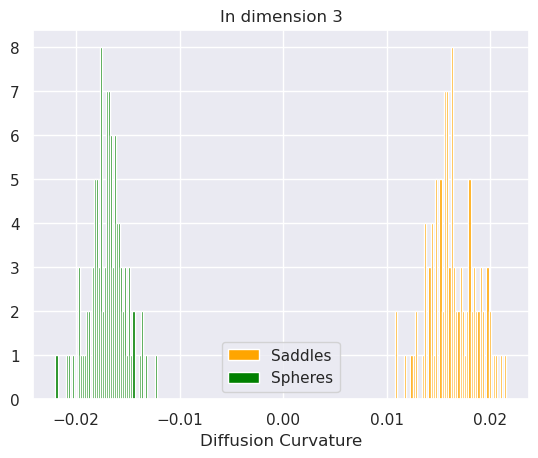

In [25]:
ksaddles, kspheres = get_dc_of_saddles_and_spheres(
    graph_former = partial(
        graph_from_adaptive_gaussian_kernel, k=10, alpha=0),
    dim = 3, 
    return_data = True
)

How bizarre, removing the anisotropic density correction, restores some of the detection of negative curvature.
Why could this be? Perhaps it's because positive and negatively curved areas actually have different densities. By normalizing this, we're forcing them to look more alike.

  0%|          | 0/100 [00:00<?, ?it/s]

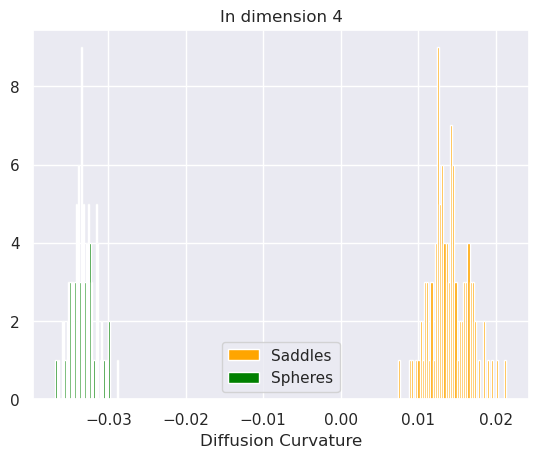

In [26]:
ksaddles, kspheres = get_dc_of_saddles_and_spheres(
    graph_former = partial(
        graph_from_adaptive_gaussian_kernel, k=10, alpha=0),
    dim = 4, 
    return_data = True
)

  0%|          | 0/100 [00:00<?, ?it/s]

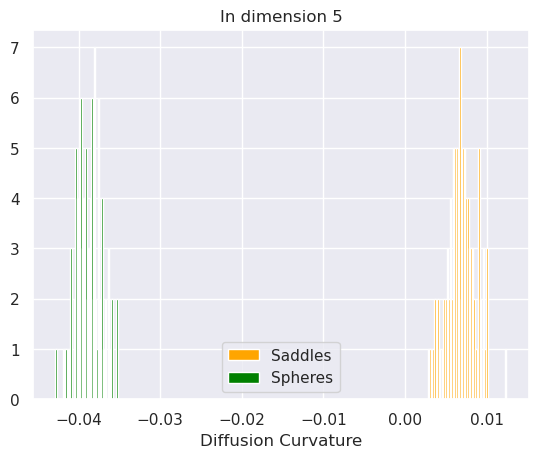

In [27]:
ksaddles, kspheres = get_dc_of_saddles_and_spheres(
    graph_former = partial(
        graph_from_adaptive_gaussian_kernel, k=10, alpha=0),
    dim = 5, 
    return_data = True
)